In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 81.0 MB/s 
     |████████████████████████████████| 103 kB 63.6 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 4
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "point_of_interest"], train_data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,91.77%,8.23%
validation set - fold 0,95.09%,4.91%
development set - fold 1,93.06%,6.94%
validation set - fold 1,91.79%,8.21%
development set - fold 2,93.07%,6.93%
validation set - fold 2,91.77%,8.23%
development set - fold 3,93.07%,6.93%
validation set - fold 3,91.76%,8.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0383844
[100]	valid_0's binary_logloss: 0.0377322
[150]	valid_0's binary_logloss: 0.0377973

CV-accuracy: 0.987568589793366


In [ ]:
del train_data
gc.collect()

407

#Check Feature Importances

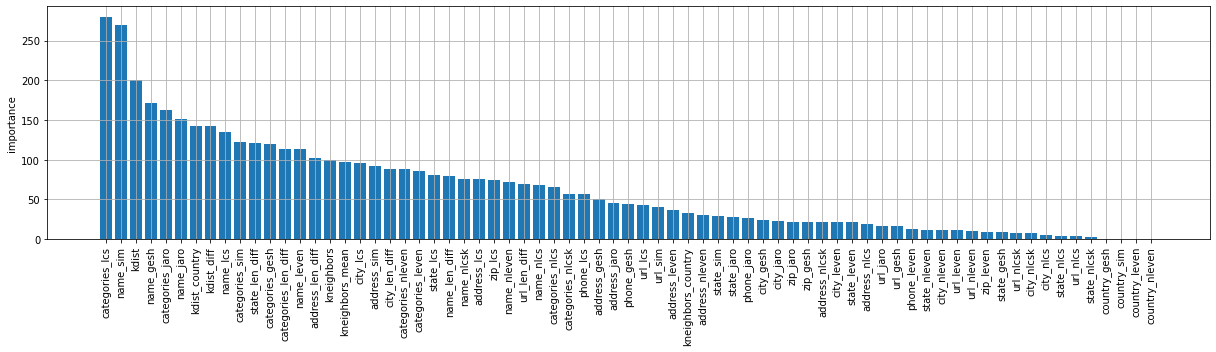

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 11.5 MB/s 
     |████████████████████████████████| 210 kB 83.3 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 80.3 MB/s 
     |████████████████████████████████| 146 kB 82.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=353c091eea7b9ebae20d7619372198def9be840cdd7927ace8bc8577ac8df0d5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 10:43:58,204] A new study created in memory with name: no-name-76c5c249-78c8-4459-b9f4-5bcf767f4d3d
[I 2022-05-25 10:44:21,894] Trial 0 finished with value: 0.8208799506470359 and parameters: {'threshold': 0.4306293358963409}. Best is trial 0 with value: 0.8208799506470359.


CV: 0.820880


[I 2022-05-25 10:44:37,919] Trial 1 finished with value: 0.8216166068858929 and parameters: {'threshold': 0.5037132037047154}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.821617


[I 2022-05-25 10:44:54,257] Trial 2 finished with value: 0.8115781439102847 and parameters: {'threshold': 0.7058340635117266}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.811578


[I 2022-05-25 10:45:10,252] Trial 3 finished with value: 0.8204217518192354 and parameters: {'threshold': 0.4189405108618519}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.820422


[I 2022-05-25 10:45:25,602] Trial 4 finished with value: 0.6835854128247499 and parameters: {'threshold': 0.9850084485548273}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.683585


[I 2022-05-25 10:45:41,653] Trial 5 finished with value: 0.8197755137725866 and parameters: {'threshold': 0.39839743106360404}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.819776


[I 2022-05-25 10:45:59,014] Trial 6 finished with value: 0.803984995308216 and parameters: {'threshold': 0.23915215831077452}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.803985


[I 2022-05-25 10:46:15,670] Trial 7 finished with value: 0.8209556998579177 and parameters: {'threshold': 0.5543386987352164}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.820956


[I 2022-05-25 10:46:34,784] Trial 8 finished with value: 0.693225331548062 and parameters: {'threshold': 0.0483263803440076}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.693225


[I 2022-05-25 10:46:51,601] Trial 9 finished with value: 0.8212490915814096 and parameters: {'threshold': 0.4473539540264524}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.821249


[I 2022-05-25 10:47:07,131] Trial 10 finished with value: 0.8080938883706811 and parameters: {'threshold': 0.7347164600411975}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.808094


[I 2022-05-25 10:47:24,566] Trial 11 finished with value: 0.7973812281159119 and parameters: {'threshold': 0.20773074628056143}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.797381


[I 2022-05-25 10:47:39,958] Trial 12 finished with value: 0.8165866412665826 and parameters: {'threshold': 0.6485412905310798}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.816587


[I 2022-05-25 10:47:55,658] Trial 13 finished with value: 0.7692882435495195 and parameters: {'threshold': 0.8874094947472784}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.769288


[I 2022-05-25 10:48:12,848] Trial 14 finished with value: 0.8050606934853509 and parameters: {'threshold': 0.24601848099208612}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.805061


[I 2022-05-25 10:48:28,681] Trial 15 finished with value: 0.8215246703542457 and parameters: {'threshold': 0.5249109287266094}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.821525


[I 2022-05-25 10:48:45,087] Trial 16 finished with value: 0.8208583815294619 and parameters: {'threshold': 0.5600301963524366}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.820858


[I 2022-05-25 10:49:01,168] Trial 17 finished with value: 0.7995259986566371 and parameters: {'threshold': 0.7869716221917498}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.799526


[I 2022-05-25 10:49:16,841] Trial 18 finished with value: 0.8195406362568322 and parameters: {'threshold': 0.5958256730099186}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.819541


[I 2022-05-25 10:49:34,071] Trial 19 finished with value: 0.8111779750832202 and parameters: {'threshold': 0.28836036269371385}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.811178


[I 2022-05-25 10:49:50,114] Trial 20 finished with value: 0.8157626918445053 and parameters: {'threshold': 0.33445460293585616}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.815763


[I 2022-05-25 10:50:06,824] Trial 21 finished with value: 0.8216162856362649 and parameters: {'threshold': 0.5036888107440414}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.821616


[I 2022-05-25 10:50:23,745] Trial 22 finished with value: 0.8214270877381147 and parameters: {'threshold': 0.5278705668247179}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.821427


[I 2022-05-25 10:50:39,376] Trial 23 finished with value: 0.8166015207660504 and parameters: {'threshold': 0.6483962458626341}. Best is trial 1 with value: 0.8216166068858929.


CV: 0.816602


[I 2022-05-25 10:50:56,021] Trial 24 finished with value: 0.8216449478681397 and parameters: {'threshold': 0.47965225999038863}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821645


[I 2022-05-25 10:51:13,974] Trial 25 finished with value: 0.7638789759893849 and parameters: {'threshold': 0.11769084264763274}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.763879


[I 2022-05-25 10:51:30,129] Trial 26 finished with value: 0.8181463539441363 and parameters: {'threshold': 0.3678609593581673}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.818146


[I 2022-05-25 10:51:46,651] Trial 27 finished with value: 0.8215974661746587 and parameters: {'threshold': 0.4956138447945946}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821597


[I 2022-05-25 10:52:02,751] Trial 28 finished with value: 0.792960401660614 and parameters: {'threshold': 0.8176615752435734}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.792960


[I 2022-05-25 10:52:18,650] Trial 29 finished with value: 0.8214474800219751 and parameters: {'threshold': 0.46235690867165224}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821447


[I 2022-05-25 10:52:35,146] Trial 30 finished with value: 0.8167868940883609 and parameters: {'threshold': 0.6457376293857677}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.816787


[I 2022-05-25 10:52:51,747] Trial 31 finished with value: 0.8216275310387843 and parameters: {'threshold': 0.4733402633039107}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821628


[I 2022-05-25 10:53:07,855] Trial 32 finished with value: 0.8154761819258536 and parameters: {'threshold': 0.33109198949868557}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.815476


[I 2022-05-25 10:53:24,472] Trial 33 finished with value: 0.8214414614948725 and parameters: {'threshold': 0.46286722036851263}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821441


[I 2022-05-25 10:53:41,056] Trial 34 finished with value: 0.8197303142369167 and parameters: {'threshold': 0.5919396810806131}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.819730


[I 2022-05-25 10:53:58,093] Trial 35 finished with value: 0.8191766559034342 and parameters: {'threshold': 0.3851113146487568}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.819177


[I 2022-05-25 10:54:14,858] Trial 36 finished with value: 0.8204614395518631 and parameters: {'threshold': 0.42070995947365786}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820461


[I 2022-05-25 10:54:31,201] Trial 37 finished with value: 0.8102557341571363 and parameters: {'threshold': 0.7172267106351713}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.810256


[I 2022-05-25 10:54:47,877] Trial 38 finished with value: 0.8216377836585842 and parameters: {'threshold': 0.48743402713905437}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821638


[I 2022-05-25 10:55:04,469] Trial 39 finished with value: 0.8191134081710627 and parameters: {'threshold': 0.6037102252920757}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.819113


[I 2022-05-25 10:55:21,543] Trial 40 finished with value: 0.7785315062262336 and parameters: {'threshold': 0.14773931327917122}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.778532


[I 2022-05-25 10:55:38,191] Trial 41 finished with value: 0.8214635715498974 and parameters: {'threshold': 0.461653661747753}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821464


[I 2022-05-25 10:55:54,651] Trial 42 finished with value: 0.8215920638652913 and parameters: {'threshold': 0.49337492141983774}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821592


[I 2022-05-25 10:56:11,519] Trial 43 finished with value: 0.8195848698476046 and parameters: {'threshold': 0.39383014997904364}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.819585


[I 2022-05-25 10:56:28,324] Trial 44 finished with value: 0.8208431268610991 and parameters: {'threshold': 0.5603222541718033}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820843


[I 2022-05-25 10:56:44,507] Trial 45 finished with value: 0.8152466369434359 and parameters: {'threshold': 0.3283518543984931}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.815247


[I 2022-05-25 10:57:01,196] Trial 46 finished with value: 0.8208149450035891 and parameters: {'threshold': 0.4279399562887434}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820815


[I 2022-05-25 10:57:17,900] Trial 47 finished with value: 0.8215500010189708 and parameters: {'threshold': 0.5125593748504981}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821550


[I 2022-05-25 10:57:33,472] Trial 48 finished with value: 0.8151902734580481 and parameters: {'threshold': 0.6674422426968776}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.815190


[I 2022-05-25 10:57:50,523] Trial 49 finished with value: 0.810870111847245 and parameters: {'threshold': 0.28588057814756795}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.810870


[I 2022-05-25 10:58:07,313] Trial 50 finished with value: 0.8210122132511671 and parameters: {'threshold': 0.5519323128376872}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821012


[I 2022-05-25 10:58:23,420] Trial 51 finished with value: 0.8215967337508874 and parameters: {'threshold': 0.4941351659379971}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821597


[I 2022-05-25 10:58:40,112] Trial 52 finished with value: 0.8215732896490622 and parameters: {'threshold': 0.4687776486423666}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821573


[I 2022-05-25 10:58:56,622] Trial 53 finished with value: 0.8188296080214895 and parameters: {'threshold': 0.6101700975386383}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.818830


[I 2022-05-25 10:59:12,528] Trial 54 finished with value: 0.8206031664665351 and parameters: {'threshold': 0.4244380371067056}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820603


[I 2022-05-25 10:59:29,046] Trial 55 finished with value: 0.8211848920310386 and parameters: {'threshold': 0.5404451773290962}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821185


[I 2022-05-25 10:59:45,584] Trial 56 finished with value: 0.821600028413264 and parameters: {'threshold': 0.5065764881598479}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821600


[I 2022-05-25 11:00:02,115] Trial 57 finished with value: 0.8203395052904887 and parameters: {'threshold': 0.5764334395991482}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820340


[I 2022-05-25 11:00:18,173] Trial 58 finished with value: 0.8180025703766318 and parameters: {'threshold': 0.36542816994681365}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.818003
CV: 0.157616


[I 2022-05-25 11:00:55,531] Trial 59 finished with value: 0.15761627418227847 and parameters: {'threshold': 0.0010324168564997405}. Best is trial 24 with value: 0.8216449478681397.
[I 2022-05-25 11:01:11,217] Trial 60 finished with value: 0.8128050878504847 and parameters: {'threshold': 0.693391541000283}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.812805


[I 2022-05-25 11:01:28,443] Trial 61 finished with value: 0.8216233757404584 and parameters: {'threshold': 0.500689764635466}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821623


[I 2022-05-25 11:01:45,451] Trial 62 finished with value: 0.821597436776141 and parameters: {'threshold': 0.5085782704188494}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821597


[I 2022-05-25 11:02:01,675] Trial 63 finished with value: 0.8211829825362498 and parameters: {'threshold': 0.4413897804276659}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821183


[I 2022-05-25 11:02:18,439] Trial 64 finished with value: 0.8213609294539161 and parameters: {'threshold': 0.5316685967725918}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821361


[I 2022-05-25 11:02:34,807] Trial 65 finished with value: 0.817868877122771 and parameters: {'threshold': 0.6283798003078666}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.817869


[I 2022-05-25 11:02:49,409] Trial 66 finished with value: 0.7001269736945065 and parameters: {'threshold': 0.9750032255349061}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.700127


[I 2022-05-25 11:03:06,388] Trial 67 finished with value: 0.8216319668791364 and parameters: {'threshold': 0.48120631422692545}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821632


[I 2022-05-25 11:03:23,558] Trial 68 finished with value: 0.8192381897483638 and parameters: {'threshold': 0.38703183532185403}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.819238


[I 2022-05-25 11:03:40,466] Trial 69 finished with value: 0.8216131832163663 and parameters: {'threshold': 0.47532048932889276}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821613


[I 2022-05-25 11:03:56,421] Trial 70 finished with value: 0.8167099116403705 and parameters: {'threshold': 0.3460563568916935}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.816710


[I 2022-05-25 11:04:13,210] Trial 71 finished with value: 0.82161412241766 and parameters: {'threshold': 0.47665734736276955}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821614


[I 2022-05-25 11:04:29,999] Trial 72 finished with value: 0.8202204959404968 and parameters: {'threshold': 0.4122480078325708}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820220


[I 2022-05-25 11:04:46,859] Trial 73 finished with value: 0.8212201779391245 and parameters: {'threshold': 0.4440937906793725}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821220


[I 2022-05-25 11:05:03,423] Trial 74 finished with value: 0.8203944571160691 and parameters: {'threshold': 0.5742354912924439}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820394


[I 2022-05-25 11:05:19,291] Trial 75 finished with value: 0.8216196967791333 and parameters: {'threshold': 0.4816569746227138}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821620


[I 2022-05-25 11:05:36,598] Trial 76 finished with value: 0.8209554071542018 and parameters: {'threshold': 0.5543494468016723}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820955


[I 2022-05-25 11:05:53,220] Trial 77 finished with value: 0.821515361749713 and parameters: {'threshold': 0.5242927677843444}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821515


[I 2022-05-25 11:06:09,019] Trial 78 finished with value: 0.8216377836585842 and parameters: {'threshold': 0.4874307965618028}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.821638


[I 2022-05-25 11:06:27,231] Trial 79 finished with value: 0.8122584182894202 and parameters: {'threshold': 0.297253363782781}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.812258


[I 2022-05-25 11:06:44,293] Trial 80 finished with value: 0.820166339144553 and parameters: {'threshold': 0.4111974560242978}. Best is trial 24 with value: 0.8216449478681397.


CV: 0.820166


[I 2022-05-25 11:07:01,922] Trial 81 finished with value: 0.8216605064287187 and parameters: {'threshold': 0.48652607913031404}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821661


[I 2022-05-25 11:07:18,404] Trial 82 finished with value: 0.8216122788355583 and parameters: {'threshold': 0.4844986317206513}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821612


[I 2022-05-25 11:07:35,522] Trial 83 finished with value: 0.8214029389919321 and parameters: {'threshold': 0.45792621783274884}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821403


[I 2022-05-25 11:07:52,860] Trial 84 finished with value: 0.8212049494103213 and parameters: {'threshold': 0.4429039977576902}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821205


[I 2022-05-25 11:08:10,583] Trial 85 finished with value: 0.8201598970191982 and parameters: {'threshold': 0.5824923123415686}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.820160


[I 2022-05-25 11:08:28,343] Trial 86 finished with value: 0.818094383822141 and parameters: {'threshold': 0.3668581203729878}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.818094


[I 2022-05-25 11:08:44,326] Trial 87 finished with value: 0.8213844822033809 and parameters: {'threshold': 0.5299327420273565}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821384


[I 2022-05-25 11:09:00,854] Trial 88 finished with value: 0.8179563290959273 and parameters: {'threshold': 0.6266024564966282}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.817956


[I 2022-05-25 11:09:18,528] Trial 89 finished with value: 0.8216009517472855 and parameters: {'threshold': 0.4927307484631012}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821601


[I 2022-05-25 11:09:35,628] Trial 90 finished with value: 0.8198415853586659 and parameters: {'threshold': 0.4014561714982591}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.819842


[I 2022-05-25 11:09:52,802] Trial 91 finished with value: 0.821564768380854 and parameters: {'threshold': 0.51306763432332}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821565


[I 2022-05-25 11:10:09,160] Trial 92 finished with value: 0.8210216559164641 and parameters: {'threshold': 0.5497579987326929}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821022


[I 2022-05-25 11:10:26,975] Trial 93 finished with value: 0.8213908605570293 and parameters: {'threshold': 0.45614707600157833}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821391


[I 2022-05-25 11:10:42,962] Trial 94 finished with value: 0.8210103444391174 and parameters: {'threshold': 0.4344538670927398}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821010


[I 2022-05-25 11:10:59,525] Trial 95 finished with value: 0.8216373234423687 and parameters: {'threshold': 0.4804749694897724}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821637


[I 2022-05-25 11:11:15,379] Trial 96 finished with value: 0.8215993532709086 and parameters: {'threshold': 0.4901156455991409}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821599


[I 2022-05-25 11:11:31,935] Trial 97 finished with value: 0.8213015298631909 and parameters: {'threshold': 0.534486935227612}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821302


[I 2022-05-25 11:11:48,215] Trial 98 finished with value: 0.8206296356634641 and parameters: {'threshold': 0.5681199641352095}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.820630


[I 2022-05-25 11:12:04,698] Trial 99 finished with value: 0.8216310256744676 and parameters: {'threshold': 0.4735813880227435}. Best is trial 81 with value: 0.8216605064287187.


CV: 0.821631


In [ ]:
threshold = study.best_params['threshold']
threshold

0.48652607913031404

In [ ]:
study.best_value

0.8216605064287187

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.821661


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,145572.000000,145572.000000,141054.000000,141054.000000,136009.000000,149762.000000,149762.0,149762.000000,149762.000000,149762.000000,...,149762.000000,149758.000000,149758.000000,149758.000000,149758.000000,149762.000000,149758.000000,149758.000000,149758.000000,149762.000000
mean,0.006250,6.264639,0.003487,6.294412,0.422998,6.559197,1.0,0.261102,0.411293,16.364679,...,0.998685,0.998815,0.002457,0.998789,1.997630,0.000027,0.001229,0.998815,0.998815,0.185392
std,0.046330,5.204427,0.022988,5.218519,2.328827,5.271725,0.0,0.306764,0.250383,9.445789,...,0.036245,0.033696,0.069295,0.034433,0.067392,0.005168,0.034647,0.033696,0.033696,0.148180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008
25%,0.000442,2.000000,0.000332,2.000000,0.005909,2.000000,1.0,0.000000,0.208333,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.049442
50%,0.001100,5.000000,0.000845,5.000000,0.056223,5.000000,1.0,0.000000,0.394737,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.154778
75%,0.003044,10.000000,0.002346,10.000000,0.319621,10.000000,1.0,0.509813,0.592593,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.308043
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.486521


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
7667857,E_7748b0dc12b3dc,E_d72d963a8fb83f,0.000775,13.0,P_c564322c19b3c6,0.000759,14.0,0.020510,13.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.014202
1511784,E_a771a6862eed61,E_6208ca51c8b9c8,0.001982,2.0,P_cc86f54483e364,0.001241,2.0,0.596892,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.169819
1504937,E_a45734be199ea8,E_d1e7f671048572,0.001048,2.0,P_b2d118e393b101,0.001017,2.0,0.031023,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.352652
5501491,E_a9289200652e18,E_3c558d087990b3,0.001251,9.0,P_1cb724bc5acf6b,0.001250,9.0,0.001239,9.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.088464
1740332,E_0e6960ff1502f9,E_a42ad909d413e6,0.000358,3.0,P_9dc8f93a7f9631,0.000358,3.0,0.002705,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.102243
7742244,E_989621c72244eb,E_4cb9da88c6b770,0.001985,13.0,P_27159ecb7469c5,0.001978,13.0,0.003450,13.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.166305
4429346,E_c72c19f7e40cdf,E_c69363d6cb7f19,0.000432,7.0,P_7132ff6b9989bf,0.000428,7.0,0.008517,7.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.213500
9414964,E_88b203be1ab469,E_61c5466c166e95,0.003079,16.0,NaN,NaN,NaN,NaN,16.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.039122
954587,E_ace2b88d2e9558,E_ea5db02e11b7e7,0.000166,1.0,P_14dea19a1af8fc,0.000165,1.0,0.002692,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.206912
627978,E_1a4010f45f21a3,E_3a5a913294e3d7,0.000082,1.0,P_2230e55e9fc587,0.000049,1.0,0.688212,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.178482


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
318382,E_478d410ffb7c31,Walmart Supercenter,46.703298,-92.452373,1308 Highway 33 S,Cloquet,MN,55720,US,https://www.walmart.com/store/1929/cloquet-mn/...,2188780737,"Big Box Stores, Supermarkets, Grocery Stores",P_291eb6e3fbdf08,1,1.0
418175,E_5df18aa24e8de9,Walmart Gas Station,46.703589,-92.455550,1308 Highway 33 S,Cloquet,MN,55720,US,NaN,NaN,Gas Stations,P_291eb6e3fbdf08,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
281512,E_3f2e8417afecfe,XFINITY Store by Comcast,29.738883,-95.501487,2616 S Voss Rd,Houston,TX,77057,US,https://www.xfinity.com/local/tx/houston/2616-...,+18009346489,"Business Services, Mobile Phone Shops, IT Serv...",P_debdcdbc2a3374,2,1.0
942882,E_d3cafb5fa998cb,Xfinity Store,29.738929,-95.501325,NaN,Houston,TX,NaN,US,NaN,NaN,Electronics Stores,P_debdcdbc2a3374,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
43613,E_09c207642b0bfd,Kota Tua - Jakarta Kota,-6.134429,106.812632,NaN,NaN,NaN,NaN,ID,NaN,NaN,Monuments / Landmarks,P_160c95c628b31d,4,1.0
322698,E_488d2bf72e233a,Kawasan Kota Tua,-6.135940,106.813111,Kota Tua,"Jakarta Pusat, DKI Jakarta",NaN,NaN,ID,NaN,NaN,Performing Arts Venues,P_160c95c628b31d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185869,E_29b3d67a58d850,Ruang Sipil SMK 1 CIMAHI,-6.900895,107.538539,Mahar Martanegara no 48,Cimahi Selatan,West Java,NaN,ID,NaN,NaN,NaN,P_886363f95334cf,4,1.0
571703,E_8083e7d0cfd2ef,SMK Negeri 1 Cimahi,-6.902120,107.538200,Jalan Mahar Martanegara No. 48,NaN,NaN,40533,ID,http://www.smkn1-cmi.sch.id,226654224,College Classrooms,P_886363f95334cf,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
793281,E_b22c07eef13fc7,Eston Deniz Marina,40.979216,28.661057,Marmara mah.,İstanbul,NaN,NaN,TR,NaN,NaN,"Harbors / Marinas, Housing Developments",P_e163b1af477cfc,2,1.0
1008863,E_e29a9bcdf04240,Eston Deniz Villaları,40.965714,28.654226,Yakamoz Mh. Yakuplu,İstanbul,Türkiye,34524,TR,NaN,2124444151,"Offices, Housing Developments",P_e163b1af477cfc,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
110268,E_18b47ad8ebb8da,SMK Kartini Baloi,1.121821,104.006066,Komplek Baloi View Baloi Indah,Batam,Kepulauan Riau,NaN,ID,NaN,7787020916,"High Schools, Schools",P_306cec7ceda193,2,1.0
707264,E_9edb5a5d0d255e,SMK KARTINI XII ACCOUNTING 3,1.122746,104.005838,Komplek Baloi View Batam,Batam,NaN,NaN,ID,NaN,NaN,College Classrooms,P_306cec7ceda193,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
217619,E_30dfb45a3b322b,BEST WESTERN Tarobá Hotel e Eventos,-25.534590,-54.588210,"R. Tarobá, 1048",Foz do Iguaçu,PR,85851-220,BR,http://www.hoteltarobafoz.com.br,4521027770,Hotels,P_ecbfae250c261a,1,1.0
750520,E_a89c7a4f192184,Hotel Taroba,-25.534662,-54.588145,NaN,NaN,NaN,NaN,BR,NaN,NaN,Scenic Lookouts,P_ecbfae250c261a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
225129,E_328c2ea7741f11,Wc smpn 12 bandung,-6.865817,107.593012,NaN,Bandung,NaN,NaN,ID,NaN,NaN,NaN,P_e2ccda6d845973,4,1.0
961105,E_d7e6cca7d0d05b,7C SMP 12 Bandung,-6.865864,107.593381,Jln. Dr. Setiabudi No. 195,Bandung,West Java,NaN,ID,NaN,NaN,"College Classrooms, College Academic Buildings",P_e2ccda6d845973,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
466531,E_68d356d89ccacb,โลตัส บางแก้ว,13.652754,100.679743,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_f2acc150dce00d,4,1.0
574914,E_8139e884373f55,Lotus # บางนา,13.653337,100.679149,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_f2acc150dce00d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
922527,E_cf3baa0579f5c8,Seaport Interdiction,-5.869244,105.754553,Pelabuhan Bakauheni,NaN,NaN,NaN,ID,NaN,NaN,Offices,P_2769dafac3aa32,4,1.0
1081178,E_f2f41fc05cf8b1,bangkaheuni,-5.869015,105.755929,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_2769dafac3aa32,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
70756,E_0fd44d7e97ac22,XI IPS 3 SMAN 18 Bandung,-6.934045,107.584236,Madesa18,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_2def4196d659ce,4,1.0
692574,E_9b8fae99391b6b,XII IPA 4,-6.936268,107.584788,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_2def4196d659ce,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
711148,E_9fbc35bc092e16,신세계백화점 (SHINSEGAE Department Store),37.505001,127.004244,서초구 신반포로 176,서울특별시,서울특별시,06546,KR,http://www.shinsegae.com,15881234,Department Stores,P_39e988260915eb,4,1.0
721930,E_a22a400f040e77,KIEHL'S,37.505238,127.004181,NaN,NaN,NaN,NaN,KR,NaN,NaN,Cosmetics Shops,P_39e988260915eb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
75936,E_1102ba3d796d52,Кабинет 9 физмата,55.158776,61.417847,NaN,NaN,NaN,NaN,RU,NaN,NaN,Speakeasies,P_c319d7677eb6b5,4,1.0
524569,E_75ded9c4870875,"Большой спорт-зал, 11 Лицей",55.159434,61.419257,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_c319d7677eb6b5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
26106,E_05d8d5ae2043dd,Зелёные холмы 🍃🌳,55.682361,37.669733,Гимназия 1527,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e5cbe4606de46c,4,1.0
306967,E_44f0ed483016b1,Кабинет Немецкого И Немецкой Литературы 420,55.682516,37.669144,NaN,город Москва,Москва,NaN,RU,NaN,NaN,College Academic Buildings,P_e5cbe4606de46c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
302392,E_43e5bfc47e3f49,Hilton Room 428,25.807960,-80.318261,NaN,Miami,FL,33122,US,NaN,NaN,Rest Areas,P_6aac767d3bd804,1,1.0
969514,E_d9c7fbc70f84d0,Hilton Garden Inn,25.808031,-80.318250,3550 NW 74th Ave,Miami,FL,33122,US,https://www.hilton.com/en/hotels/miaaigi-hilto...,+13056297701,Hotels,P_6aac767d3bd804,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
206881,E_2e6cf3eaf83f85,Ateliê da Teka,-27.630577,-52.275289,NaN,NaN,NaN,NaN,BR,NaN,NaN,Tailor Shops,P_4d0a5e7b262250,1,1.0
346066,E_4dc3f71f028fec,Atêlie da Teca,-27.630772,-52.275189,NaN,NaN,NaN,NaN,BR,NaN,NaN,Knitting Stores,P_4d0a5e7b262250,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
296588,E_429aa766062ac1,Кабинет Географии,47.227259,39.710271,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_613491920498a5,1,1.0
449818,E_6512db02182122,Лицей №33,47.227219,39.710319,"ул. Красноармейская, 158/73",Ростов-на-Дону,Ростовская обл.,344002,RU,http://www.lyceum-33.narod.ru,8632406876,"Schools, High Schools",P_613491920498a5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388504,E_5744b4cf1b8022,LDC DPE,47.825148,-0.315950,NaN,NaN,NaN,NaN,FR,NaN,NaN,Factories,P_360b154e444a1a,2,1.0
824691,E_b92f1bd8fbac9a,LDC Siege,47.825327,-0.315567,NaN,NaN,NaN,NaN,FR,NaN,NaN,Factories,P_360b154e444a1a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
70000,E_0fa9f3df987fef,MaRI Arcade (Ratu Indah Mall),-5.153403,119.416751,Jl. Dr. Ratulangi,Makassar,Sulawesi Selatan,NaN,ID,NaN,NaN,Asian Restaurants,P_901fe526e63f5a,4,1.0
1003537,E_e16d321b7d7368,Ratu Indah Mall,-5.153901,119.414675,Jalan Ratulangi,Makassar,Indonesia Timur,95222,ID,NaN,NaN,Shopping Malls,P_901fe526e63f5a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
92631,E_14c44f5d067e30,centro de dísnostico,11.004196,-74.818550,NaN,NaN,NaN,NaN,CO,NaN,NaN,Medical Centers,P_b6584972a48601,4,1.0
390357,E_57b035f04327ae,Centro Comercial Buenavista I,11.013445,-74.827561,Cl 98 # 52 - 115,Barranquilla,Atlántico,NaN,CO,http://ccbuenavistabarranquilla.com,53188100,Shopping Malls,P_b6584972a48601,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
753813,E_a951f94dab4d05,Luokka K1,61.568726,23.601049,"Kuusistontie, 33480 Tampere",NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_529b2937cef756,4,1.0
779489,E_af14e62920ca9b,Moision koulu,61.568902,23.600641,Kuusistontie 1,Ylöjärvi,NaN,33480,FI,NaN,NaN,"Schools, High Schools",P_529b2937cef756,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
37405,E_0864930511b87e,Dive-Ex EudiSHOW,44.513763,11.368514,Bologna Fiere,Bologna,Emilia-Romagna,40128,IT,http://www.eudishow.eu,+39039879832,Event Spaces,P_e1f3735806543e,4,1.0
704448,E_9e3795c3d44a10,SAME DEUTZ-FAHR at EIMA,44.513270,11.365916,NaN,NaN,NaN,NaN,IT,NaN,NaN,Event Spaces,P_e1f3735806543e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
348944,E_4e6a64e365f12b,高槻中学4階トイレ,34.848361,135.628771,沢良木町2-5,高槻市,大阪府,569-0084,JP,NaN,NaN,NaN,P_b56518c5398652,4,1.0
395624,E_58e49dd0614eff,高槻高校1年3組教室,34.847991,135.628051,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_b56518c5398652,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
483537,E_6cabfe334f5526,Wisata Belanja Tugu (Pasar Minggu),-7.973632,112.624277,Jl. Semeru,Malang,East Java,NaN,ID,NaN,NaN,"Miscellaneous Shops, Street Fairs, General Ent...",P_e189e7520ea649,4,1.0
817496,E_b795fb8758915b,Sunday Market,-7.974461,112.625279,NaN,Malang,Malang,NaN,ID,NaN,NaN,Markets,P_e189e7520ea649,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93055,E_14dd017ce93e60,Osmaneli,40.309059,30.074820,NaN,Osmaneli/Bilecik,osmaneli,NaN,TR,NaN,NaN,NaN,P_78bf13ba964f3e,1,1.0
300391,E_43757121dab9b7,Herhangi Bir Yer,40.358486,30.016264,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_78bf13ba964f3e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
570574,E_8042b2e1aefdde,高橋朱里レーン,35.459446,139.634841,神奈川県,横浜市西区,NaN,NaN,JP,NaN,NaN,Other Events,P_d5bdd70e98352d,4,1.0
1013822,E_e3c4be022eb18e,パシフィコ横浜,35.459586,139.633850,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_d5bdd70e98352d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
59518,E_0d4f35bd17324d,Coach House Diner & Restaurant,40.896660,-74.03842,55 State St,Hackensack,NJ,07601,US,NaN,+12014884999,Food,P_8cc94314d41a9d,2,1.0
638665,E_8f94552d11bae6,Coach House Diner And Restaraunt(Outside Dinin...,40.904544,-74.03297,NaN,Hackensack,NJ,07601,US,NaN,NaN,Diners,P_8cc94314d41a9d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33510,E_07811102cdc5ee,Природоведение,59.937758,30.479756,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Cafeterias,P_bc8f3d679b05cc,4,1.0
779476,E_af1400167f2f86,Страноведение,59.937687,30.479520,NaN,NaN,NaN,NaN,RU,NaN,NaN,Schools,P_bc8f3d679b05cc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
214017,E_300cb69e9ae3eb,Пляж Финского залива,60.176656,29.083621,37 км Приморского шоссе,Выборгский район,Ленинградская область,NaN,RU,NaN,NaN,Beaches,P_ec447a242a9e47,2,1.0
317320,E_474eff3c28247f,финский залив 🌊,60.184525,29.086505,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_ec447a242a9e47,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95653,E_1572d814b3360c,Формула кино,55.766241,37.382076,ТЦ «Европарк»,Москва,NaN,121500,RU,http://www.formulakino.ru,4957953795,Multiplexes,P_fcb5e1caa30dc1,4,1.0
738219,E_a5d80c3f296295,Зал Номер 2,55.766193,37.382022,Рублево-успенское Шоссе,Москва,NaN,NaN,RU,NaN,NaN,Movie Theaters,P_fcb5e1caa30dc1,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,63947.000000,63947.000000,60583.000000,60583.000000,58801.000000,65133.000000,65133.0,65133.000000,65133.000000,65133.000000,...,65133.000000,65129.000000,65129.000000,65129.000000,65129.000000,65133.0,65129.000000,65129.000000,65129.000000,65133.000000
mean,0.019781,4.721082,0.003630,4.518842,0.398610,4.974706,0.0,0.583586,0.603258,12.139207,...,0.997329,0.997682,0.004775,0.997687,1.995363,0.0,0.002388,0.997682,0.997682,0.692058
std,0.250593,5.043307,0.018494,4.861816,1.721001,5.159265,0.0,0.360475,0.252230,9.292568,...,0.051617,0.046554,0.095301,0.047001,0.093108,0.0,0.047651,0.046554,0.046554,0.139698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.486528
25%,0.000304,1.000000,0.000227,1.000000,0.007550,1.000000,0.0,0.319003,0.434783,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.571425
50%,0.000938,2.000000,0.000671,2.000000,0.064657,2.500000,0.0,0.669210,0.620690,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.672921
75%,0.003419,7.000000,0.002255,6.000000,0.308760,7.500000,0.0,0.909886,0.800000,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.799317
max,25.356492,19.000000,1.385816,19.000000,134.220750,19.000000,0.0,1.000000,1.000000,58.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999996


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1692431,E_f8ce7427e633c7,E_8723540e275912,0.002939,2.0,P_e5681929f154b2,0.002740,2.0,0.072506,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.747704
3357523,E_e54fa7161f91b0,E_3a37c7fb3a9291,0.000347,5.0,P_6bce5b060f6ca9,0.000044,1.0,6.860698,3.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.727762
9811649,E_3b1b6110458893,E_5e8079ded9b0a0,0.027323,17.0,NaN,NaN,NaN,NaN,17.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.500438
2386678,E_30e92dacb7807c,E_18d6f1b6b31045,0.007280,4.0,P_a8f096e4e58131,0.006590,4.0,0.104662,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.957931
3687337,E_79a81680805ffc,E_d730b6a2e4e9e4,0.000614,6.0,P_3a0629ae792fb2,0.000614,6.0,0.000287,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.717544
3704959,E_81a1dd1f806b99,E_fdb7ed223835ab,0.011091,6.0,P_873e8482838df2,0.008127,6.0,0.364753,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.591593
2830230,E_f85ee80d471031,E_8580f526c45d32,0.000701,4.0,P_fcea2f2d2183ba,0.000701,4.0,0.000179,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.782081
573747,E_01f71f68cfd4da,E_aeda7414c4efd4,0.001908,1.0,P_539c2fe92e65a2,0.001885,1.0,0.012257,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.816609
1425242,E_80ab00d5bbe326,E_bbc59249dc9663,0.000083,2.0,P_47e834db0f9552,0.000074,2.0,0.127926,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.537190
974562,E_b5db4286425788,E_5fd7a7722df671,0.002435,1.0,P_00866cbf527b92,0.001421,1.0,0.714041,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.566590


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
862378,E_c1b3d7c13b19ac,SMA Negeri 2 Surabaya - Gymnasium,-7.257117,112.747204,Jl. Kusuma Bangsa 48,Surabaya,Indonesia,NaN,ID,NaN,NaN,College Classrooms,P_d1c36eceb6334b,4,1.0
898105,E_c9bc716b33ebd7,7 RSBI F SMPN 1 Surabaya,-7.257129,112.747500,NaN,NaN,NaN,NaN,ID,NaN,NaN,High Schools,P_9916d26fb33ab3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231213,E_33e5cd0daf7e6e,Ruang Tunggu HCU Santosa International Hospital,-6.915685,107.600296,Jl. Kebon Jati No. 38,Bandung,Jawa Barat,40285,ID,NaN,NaN,Hospitals,P_8529a36d0a3855,4,1.0
683468,E_998515df61b216,Lt.8 berlian timur Santosa international Hospital,-6.915401,107.600392,Jl.Kebon jati,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_f96f0bab7207ca,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100725,E_1692b3083c75be,Ppt1 Quay Crane 311,1.282243,103.762162,NaN,NaN,NaN,NaN,SG,NaN,NaN,Ports,P_970ee0f9dd48d9,0,1.0
315725,E_46f37f820e104b,Ppt1 Quay Crane 105,1.288750,103.764063,NaN,NaN,NaN,NaN,SG,NaN,NaN,Ports,P_0c75b70ce0bdb7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
450340,E_6531542c21850b,Rio Slot Machines,36.116772,-115.187859,3858-4098 S Highland Dr,Las Vegas,NV,89103,US,NaN,NaN,Casinos,P_7db378f3aa7780,0,1.0
806112,E_b50790200d3f3e,Rio All-Suite Hotel & Casino,36.116762,-115.187610,3700 W Flamingo Rd,Las Vegas,NV,89103,US,http://www.riolasvegas.com,7027777777,"Casinos, Resorts",P_62bbf2c11c6a47,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
254891,E_393e8dbbabbd5b,Minnen hof 🌲🌷🌳,50.888556,3.23327,NaN,NaN,NaN,NaN,BE,NaN,NaN,Botanical Gardens,P_0cd6c233b7a8e6,0,1.0
895354,E_c91c7806830676,in min nen hof☀️🌷😎,50.890353,3.23679,NaN,NaN,NaN,NaN,BE,NaN,NaN,Gardens,P_4e76e7f1ade4a8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
489204,E_6df7c83451699d,Johnny's Pizza House,32.552903,-92.065447,912 Unity Rd,Crossett,AR,71635,US,https://johnnysph.com,+18703042000,NaN,P_859deea0426be4,1,1.0
858719,E_c0de9cd1b9855a,Johnny's Pizza House,32.552957,-92.065424,3001 Old Sterlington Rd,Monroe,LA,71203,US,https://johnnysph.com,+13183432992,"Pizza Places, Gastropubs",P_d5ae9be8221833,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
718133,E_a15074b026728c,Nimród Hotel,47.877496,17.260505,Királyhidai u. 59.,Mosonmagyaróvár,NaN,9200,HU,NaN,NaN,Hotels,P_1db048e18ee06f,0,1.0
1084984,E_f3ce6f7b8620d5,Nimród Étterem & Hotel,47.877293,17.259811,Királyhidai u. 59.,Mosonmagyaróvár,NaN,9200,HU,NaN,+3696211141,"Restaurants, Hotels",P_d1670448154af4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
383997,E_56470e7aadeafa,emamdad's garden hapuuu,37.542348,45.19145,NaN,NaN,NaN,NaN,IR,NaN,NaN,Bath Houses,P_b9d37cf4e7fda3,1,1.0
619203,E_8b39265118636a,Garden,37.534940,45.17230,Jadeh emamzadeh,Urmia,NaN,NaN,IR,NaN,NaN,Gardens,P_68b2af665f6c0a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
363154,E_5198cb592d3c71,Swiss @ Giardini,45.428961,12.357963,NaN,NaN,NaN,NaN,IT,NaN,NaN,Art Galleries,P_ac8e07aa37ad12,1,1.0
1038912,E_e96b0fdcb6a753,Biennale Architettura 2012,45.429334,12.358100,NaN,NaN,NaN,NaN,IT,NaN,NaN,"General Entertainment, Art Galleries",P_754e2416582c42,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95342,E_15600fcfa2269c,Детская площадка,59.953156,30.461374,"ул. Передовиков, 37",Санкт-Петербург,город Санкт-Петербург,195279,RU,NaN,NaN,Playgrounds,P_85f502dea65556,0,1.0
281341,E_3f2511a6194c94,Детская Площадка,59.954588,30.465822,NaN,NaN,NaN,NaN,RU,NaN,NaN,Playgrounds,P_d1dbc38046f10d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
648315,E_91b47cdc8d4d15,Taman Krakatau,-6.057893,106.073814,NaN,Serang,Banten,42161,ID,NaN,NaN,"Parks, Lakes",P_08ea136b59dc6c,0,1.0
944501,E_d4281c95813006,TAMAN KRAKATAU ZONA RIVERSIDE BLOK M7 / 2,-6.052723,106.077311,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_afe8edd1656a68,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45672,E_0a37fcd8f8351f,"Зал ожидания, Пулково-2",59.806043,30.306303,NaN,NaN,NaN,NaN,RU,NaN,NaN,Airport Lounges,P_071feb305ad8be,1,1.0
902575,E_caba7d9e1d50a1,Аэропорт Пулково-2 / Pulkovo-2 Airport (LED),59.805782,30.307953,"Стартовая ул., 17",Санкт-Петербург,Санкт-Петербург,196210,RU,http://www.pulkovoairport.ru/,8127043444,Airports,P_be532def262f7d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
286835,E_406496c1cb3294,Salihli Midder Meydanı,38.486217,28.139696,NaN,NaN,NaN,NaN,TR,NaN,NaN,Plazas,P_74c261b5087685,1,1.0
659567,E_94332469aa0fb2,Salihli,38.483804,28.138672,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Cafeterias,P_f66b6761c79342,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
367682,E_5296ac1588b989,Express,27.793330,-82.733094,6901 22nd Ave N,Saint Petersburg,FL,33710,US,https://stores.express.com/us/fl/st--petersbur...,7273438311,Clothing Stores,P_f2adfd1a4b709f,0,1.0
541853,E_79c14e664e1dd8,Urban Swag,27.793474,-82.732850,6901 22nd Ave N,Saint Petersburg,FL,33710,US,NaN,NaN,Clothing Stores,P_b9b61ba18dc7db,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
65736,E_0eb764b74d1af2,Stripes Car Wash #2168,27.703171,-97.363296,NaN,NaN,NaN,NaN,US,NaN,NaN,Automotive Shops,P_a36e76ce43571a,0,1.0
343814,E_4d428d8c258399,Firestone Complete Auto Care,27.703548,-97.361180,6050 S Padre Island Dr,Corpus Christi,TX,78412,US,http://www.firestonecompleteautocare.com,+13612883503,"Automotive Shops, Auto Workshops, Miscellaneou...",P_0e0e2c4174fa11,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387900,E_572116498557ce,Car wash 12,-6.304308,106.911309,Setu,NaN,NaN,13880,ID,NaN,NaN,"Automotive Shops, Car Washes",P_20f9fddce336a9,0,1.0
413419,E_5ce2f13734b5d3,158 Car Wash,-6.295761,106.920173,Jl.Raya Hankam No.158,NaN,NaN,NaN,ID,NaN,NaN,Car Washes,P_1bd9a6f83bcc7f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
304718,E_446e7d1b6c8c67,Аудитория 306/5 РАНХиГС,55.667108,37.477731,РАНХиГС,Moscow,Moscow,NaN,RU,NaN,NaN,College Auditoriums,P_38d1c2a2c59faf,0,1.0
1093158,E_f5af311c36a417,Аудитория 208/5 РАНХиГС,55.667073,37.477703,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_e285b6cfd3db6a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95743,E_1578a696f39632,Quintal's Bar,-6.524472,-38.409719,R. Marizete Fernandes Vieira,Uiraúna,NaN,58915-000,BR,NaN,NaN,Bars,P_a9827262b358a7,0,1.0
579462,E_8240cbf4cae3f9,Bar quentura,-6.522517,-38.410456,Rua major José Fernandes número 289,Uiraúna,Paraíba,58915-000,BR,NaN,83-99284555,Bars,P_a46eeddca626de,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
440404,E_62fa676d7a66b6,Embratel,-22.900757,-43.187937,"R. Senador Pompeu, 119",Rio de Janeiro,RJ,20221-290,BR,NaN,NaN,"Offices, Tech Startups",P_f1b74085c6dc52,0,1.0
527321,E_767dc62e4ac067,Embratel / Claro,-22.900292,-43.187127,R. Camerino 96,Rio de Janeiro,RJ,20080-010,BR,NaN,NaN,Offices,P_d4f9c1755ffec2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
260978,E_3a97114aba47ef,Ruang Kuliah II Farmasi UGM,-7.768612,110.376051,"Jl. Medika, Sekip Utara.",NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_42e7b77afe7d6e,0,1.0
515226,E_73d028ee57e960,Ruang 3 Farmasi UGM,-7.768485,110.377005,NaN,Depok,Yogyakarta,NaN,ID,NaN,NaN,College Classrooms,P_868efa1ef72cfa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
250633,E_3844fe9bc9dbc8,ELTE BTK A épület,47.493295,19.060874,Múzeum krt. 4-8.,Budapest,Budapest,1088,HU,NaN,NaN,"College Academic Buildings, College Auditoriums",P_5ee66fd92a6f4a,1,1.0
744683,E_a74dd885bde48f,Elte Btk C Épület A/7,47.493370,19.062252,NaN,Budapest,NaN,1088,HU,NaN,NaN,College Classrooms,P_bbe7615392ac03,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
424904,E_5f796d1e54e771,Tubagus Ismail I/12,-6.885776,107.615312,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_c686d031329ef2,0,1.0
734002,E_a4e239e18fed8b,Es Durian Tubagus Ismail,-6.885467,107.615610,Jl Tubagus Ismail I no 5,Bandung Regency,West Java,NaN,ID,NaN,NaN,"Juice Bars, Ice Cream Shops, Dessert Shops",P_4627a21c20800d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
459004,E_672508769568f3,虎ノ門 砂場 西新橋店,35.670108,139.751944,西新橋1-4-1,Minato,Tōkyō,NaN,JP,NaN,+81335019807,Soba Restaurants,P_7d83ec99f94847,0,1.0
942961,E_d3cfb83452bf37,虎ノ門 砂場,35.669136,139.752504,港区虎ノ門1丁目十番六号,港区,東京都,105-0003,JP,NaN,+81335019661,Soba Restaurants,P_272a5887f902d9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
166112,E_253ce94b66c324,電器のロケット,35.699269,139.770760,NaN,千代田区,東京都,101-0021,JP,NaN,NaN,Electronics Stores,P_0122ec0b1b0543,1,1.0
403887,E_5ac097c84b6a61,akibaLED ピカリ館 本館,35.699339,139.770552,外神田1-8-7,千代田区,東京都,101-0021,JP,http://www.akiba-led.jp,0362068555,"Electronics Stores, Hobby Shops",P_7dbb2df54689ac,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
888218,E_c788b1d71c45b1,Procter and Gamble Central Tower Lobby,39.102447,-84.507438,NaN,Cincinnati,OH,NaN,US,NaN,NaN,Offices,P_798963302f20f3,0,1.0
1091548,E_f550379d86a63d,PNC Center,39.101213,-84.508913,201 E 5th St,Cincinnati,OH,45202,US,https://apps.pnc.com/locator/#/result-details/...,+15136518033,"Offices, Buildings",P_b15a555958baac,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
250502,E_383d9ccaa1a241,Метро «Проспект Большевиков» (metro Prospekt B...,59.919814,30.466250,"ул. Коллонтай, 20",Санкт-Петербург,Санкт-Петербург,193318,RU,http://www.metro.spb.ru,NaN,Metro Stations,P_1b9a4cccd08ef6,4,1.0
868822,E_c32adee1bf2a1a,дыбенко метро,59.919174,30.463196,NaN,NaN,NaN,NaN,RU,NaN,NaN,Metro Stations,P_b316138f4934b0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
540098,E_795dcca526894a,Бессонница 🙈😞,55.800995,37.471503,NaN,NaN,NaN,NaN,RU,NaN,NaN,Other Nightlife,P_4c3babed2317e1,1,1.0
1069460,E_f05cf18685763e,Завтрак ☕🍳🍞,55.801104,37.471842,NaN,NaN,NaN,NaN,RU,NaN,NaN,Breakfast Spots,P_932963e14eda25,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
294300,E_4217cc7d4f487e,W3110A @ Singapore Polytechnic,1.307551,103.781773,NaN,NaN,NaN,NaN,SG,NaN,NaN,College Labs,P_876851ebb3ea10,0,1.0
1095001,E_f61b91fba63475,Singapore Polytechnic T3a31 Studio,1.307461,103.781087,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_f7f4056eb70205,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
75302,E_10dc90e438a888,Озеро Вельё,57.723396,33.049190,NaN,NaN,NaN,NaN,RU,NaN,NaN,Lakes,P_58199836349d9f,1,1.0
1059128,E_ee0543f2464637,Череменецкое озеро,58.559751,29.983834,NaN,NaN,NaN,NaN,RU,NaN,NaN,Lakes,P_062d317091d57d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
708651,E_9f2c40c7da15e5,Mie Medan Sabar Subur,-6.175837,106.631899,Depan Toserba Sabar Subur,Tangerang,NaN,NaN,ID,NaN,NaN,NaN,P_6a1cc5e04050ca,0,1.0
1065780,E_ef86609a24b0ee,Sabar subur,-6.177265,106.629940,Tangerang,NaN,NaN,NaN,ID,NaN,NaN,Markets,P_7af6010ad9a167,2,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,853395.000000,853395.000000,845518.000000,845518.000000,268013.000000,855718.000000,855718.0,855718.000000,855717.000000,855717.000000,...,855718.000000,855710.000000,855710.000000,855710.000000,855710.000000,855718.0,855710.000000,855710.000000,855710.000000,855718.000000
mean,0.001792,1.014565,0.000765,1.010065,0.426817,1.078084,1.0,0.821147,0.913460,2.689781,...,0.999522,0.999623,0.000776,0.999614,1.999246,0.0,0.000388,0.999623,0.999623,0.949261
std,0.029155,2.648671,0.005807,2.659227,1.961560,2.761388,0.0,0.346225,0.192717,6.425853,...,0.021857,0.019205,0.039268,0.019601,0.038411,0.0,0.019634,0.019205,0.019205,0.108490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.486530
25%,0.000000,0.000000,0.000000,0.000000,0.007982,0.000000,1.0,0.850709,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.966385
50%,0.000000,0.000000,0.000000,0.000000,0.069535,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999911
75%,0.000203,1.000000,0.000146,1.000000,0.338070,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999939
max,4.448372,19.000000,1.099809,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
297589,E_8593b7f0ba5807,E_8593b7f0ba5807,0.000000,0.0,P_9a91b491f0a9ec,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999950
433928,E_c2d64e293cbafc,E_c2d64e293cbafc,0.000000,0.0,P_8a161d84cc215f,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999854
444600,E_c7acab4fe46c47,E_c7acab4fe46c47,0.000000,0.0,P_3d7a0c300dfe6e,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999962
154947,E_458bc251cc934b,E_458bc251cc934b,0.000000,0.0,P_62405c040941ab,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999911
132209,E_3b4e6dc6238a6e,E_3b4e6dc6238a6e,0.000000,0.0,P_021e0a9f82aac9,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999967
1140545,E_00cde7d3d6ddf8,E_1b04d336299889,0.003476,2.0,P_8a5c9dd67ef1ed,0.002799,2.0,0.241717,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.940095
891102,E_90722a7e574c3d,E_f9810c33d9f9c8,0.000320,1.0,P_0bef3ee4b7af04,0.000255,1.0,0.256517,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.951387
262816,E_75faaffb6f42c2,E_75faaffb6f42c2,0.000000,0.0,P_c77b9b39da8db9,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999897
591750,E_0a024f9bed3c7e,E_ca7fa8ce022291,0.011059,1.0,P_aa8d7ef24d0d65,0.011059,1.0,0.000053,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.967502
356128,E_9fd7219211a2db,E_9fd7219211a2db,0.000000,0.0,P_51ba83e9922096,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999904


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
493386,E_6eea59b1d97c62,Bingöl Genç Devlet Hastanesi,38.74895,40.549946,genç devlet hastanesinde,bingöl,NaN,NaN,TR,NaN,NaN,Hospitals,P_99cf2df6788040,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
412313,E_5ca5d21975dc95,Hotel Rysy,49.091498,20.071122,Horská 78,Tatranská Štrba,POLAND,059 41,SK,http://hotelrysy.sk,+421902475183,Hotels,P_d1ecfb9712bc25,1,1.0
986615,E_dda651ac67935a,Hotel Rysy,49.091767,20.071188,NaN,NaN,NaN,NaN,SK,NaN,NaN,Comedy Clubs,P_d1ecfb9712bc25,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
115607,E_19ea11111fe6c9,Drogaria Sarai,-15.806260,-48.064834,Qnd 41 lote 02 Loja 02,Taguatinha Norte,DF,72120-410,BR,NaN,61-3354-0036,Pharmacies,P_07eea59e18f1d3,1,1.0
1094541,E_f602112444f669,Drogaria Sara'í,-15.807111,-48.075927,NaN,NaN,NaN,NaN,BR,NaN,NaN,Pharmacies,P_07eea59e18f1d3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195623,E_2be3b56d47a9da,Gerry's Cakes,37.452262,-122.185106,1141 Chestnut St,Menlo Park,CA,94025,US,NaN,+16503266282,Bakeries,P_c727d02021f87c,1,1.0
261259,E_3aa83259ad38de,Gerrys Cakes,37.451906,-122.185085,1141 Chestnut St,Menlo Park,CA,NaN,US,http://www.gerryscakes.com,4153266282,Bakeries,P_c727d02021f87c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1097510,E_f6a9f8b758555e,Барыс Арена,51.109207,71.395346,пр. Туран,Astana,Astana Qalasy,NaN,KZ,http://www.hcbarys.kz,+77172613533,Hockey Arenas,P_5299629aa95c4b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
12969,E_02f04ebca65bb0,すき家,35.674715,139.753526,霞が関1-1-4,千代田区,東京都,100-0013,JP,https://www.sukiya.jp,NaN,Donburi Restaurants,P_c13431e16251f7,1,1.0
311675,E_46043efc8644dc,すき家 東京高等裁判所内,35.675068,139.752706,1-4 B1F Kasumigaseki 1-Chōme,Chiyoda,Tokyo,100-0013,JP,NaN,NaN,Donburi Restaurants,P_c13431e16251f7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113650,E_1979180887c974,ที่ว่าการอำเภอพนมสารคาม,13.744373,101.346466,NaN,NaN,NaN,NaN,TH,NaN,NaN,Government Buildings,P_5939abb6f88ab4,1,1.0
352997,E_4f52055a54c3a1,ที่ว่าการอำเภอพนมสารคาม,13.744289,101.346721,อ.พนมสารคาม,ฉะเชิงเทรา,NaN,NaN,TH,NaN,NaN,Capitol Buildings,P_5939abb6f88ab4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
372588,E_53b85e3d536d45,MoneyGram,34.493700,-87.269683,15445 AL HIGHWAY 24,MOULTON,AL,35650-6602,US,NaN,NaN,Financial or Legal Services,P_2a5023e28f601a,1,1.0
541403,E_79a5ff3397d6c5,MoneyGram,34.493665,-87.269211,15445 AL Highway 24,Moulton,AL,35650,US,https://t.co/7sR7YQKUXH,NaN,Financial or Legal Services,P_2a5023e28f601a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
124950,E_1c013689295136,سوق الخضروات والفواكه المركزي بجازان,16.901871,42.545634,NaN,NaN,NaN,NaN,SA,NaN,NaN,Farmers Markets,P_02be6f2b983f9d,1,1.0
386854,E_56e8e9dd27d09c,سوق الخضار,16.902109,42.546079,NaN,NaN,NaN,NaN,SA,NaN,NaN,Farmers Markets,P_02be6f2b983f9d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
399813,E_59d5e9e2bb9c26,Ata Otel,37.076093,29.344729,NaN,Çameli,Denizli,NaN,TR,NaN,NaN,Hotels,P_57da96aa7f215d,1,1.0
1082817,E_f35375c5fb6f81,Ata Otel,37.076065,29.344848,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hotels,P_57da96aa7f215d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
793610,E_b23f30a5e957df,Sonic Drive-In,33.43617,-94.08037,2901 New Boston Rd,Texarkana,TX,NaN,US,NaN,9038386644,Fast Food Restaurants,P_12189da3c58f50,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93317,E_14eb32aee7c1bc,Sekretariat Kecamatan Dukuh Pakis,-7.282123,112.70832,Kantor Camat Dukuh Pakis,Surabaya,Jawa Timur,601225,ID,NaN,0315660219,Government Buildings,P_ba59ef3601d8fa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251574,E_387de7cda05e47,26 кабинет (Химия),51.566792,46.06485,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_75164f64432e11,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
344736,E_4d75fec0fa3a05,가양역,37.561326,126.854762,강서구 양천로 지하 485,서울특별시,NaN,07526,KR,http://www.metro9.co.kr,+82226560009,Metro Stations,P_12717d407969ad,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
412147,E_5c9ad59ad27ee6,ธนาคารไทยพาณิชย์ (Siam Commercial Bank),13.732044,100.512972,1280 Yotha Rd.,Samphanthawong,Bangkok,10110,TH,http://www.scb.co.th,22375000,Banks,P_c82205cb565c5c,1,1.0
777244,E_ae93b26a3e0f18,ธนาคารไทยพาณิชย์ สาขาตลาดน้อย,13.733163,100.513186,NaN,NaN,NaN,NaN,TH,NaN,NaN,Banks,P_c82205cb565c5c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1119206,E_fb9cc861c25ac7,Starmall Prima Molino,14.385378,120.979529,NaN,Bacoor,Cavite,NaN,PH,NaN,NaN,Shopping Malls,P_1648d47d9aac67,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112509,E_1937093446878d,NEW FRANK'S,41.029595,28.97541,"İstiklal Cad, Kumbaracı yokuşu 68/B Beyoğlu",İstanbul,NaN,34343,TR,NaN,2122492599,"Hot Dog Joints, Fast Food Restaurants",P_3268d3a1d64f01,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21134,E_04bf6160e25962,Me Piace,-34.918681,-57.948933,Calle 54,La Plata,Buenos Aires,1900,AR,NaN,NaN,"Argentinian Restaurants, Breakfast Spots, Cafés",P_35e516936f5e94,2,1.0
313440,E_466bf861a2ba41,Me Piace,-34.918781,-57.949291,54,La Plata,Buenos Aires,1900,AR,NaN,NaN,Italian Restaurants,P_35e516936f5e94,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
681608,E_991d7ffc4ff8e1,AutoNation INFINITI Tustin,33.726176,-117.799426,33 Auto Center Drive,Tustin,CA,92782,US,https://www.infinitioftustin.com,7146275556,"Auto Dealerships, Automotive Shops",P_15fdd189c7a6ac,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
555234,E_7cc76da3f50a4d,Lucky Chinatown,14.661486,121.052258,NaN,NaN,NaN,NaN,PH,NaN,NaN,Shopping Malls,P_ed875b9c143e2e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
31041,E_06f4a8b0c8f50c,Bart Smit,52.017065,5.177865,NaN,Houten,Utrecht,NaN,NL,http://www.bartsmit.com,NaN,Toy / Game Stores,P_3c6225f78acd9c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
476615,E_6b1f2415ac5642,Ohio Turnpike - 2 Westgate,41.629215,-84.754761,Ohio Turnpike,Edon,OH,43518,US,http://www.ohioturnpike.org,+14402342081,Toll Booths,P_2b762c333b89c8,1,1.0
938683,E_d2d72ced9d748a,OH Turnpike to IN Turnpike,41.629607,-84.760610,NaN,Edon,OH,43518,US,NaN,NaN,NaN,P_2b762c333b89c8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
48524,E_0ad9b907b3de03,Aldi,53.412569,-2.154292,NaN,NaN,NaN,NaN,GB,NaN,NaN,Supermarkets,P_c035324714e9f3,1,1.0
146703,E_20e344588184b4,Aldi,53.410914,-2.152396,New Bridge Ln.,Stockport,Stockport,SK1 2NA,GB,https://www.aldi.co.uk,+448000420800,"Supermarkets, Grocery Stores",P_c035324714e9f3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
636571,E_8f1cfa1e5eb10e,ZŠ Martina Luthera,49.746678,13.34938,Školní nám. 1,Plzeň 1,Plzeňský,318 00,CZ,http://www.ms-klubicko.cz/zakladni-skola/o-nas...,+420377387009,Elementary Schools,P_a757b94bc7a7e8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
28673,E_066de0d7d80708,GK1 - 501,1.418229,124.984638,Universitas Klabat,Minahasa Utara,Sulawesi Utara,NaN,ID,NaN,NaN,College Classrooms,P_c09ca3c44e17d6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
678301,E_985dc23bb3fd07,7/11#01764 อ่อนนุช 17 แยก 16,13.720459,100.616425,NaN,NaN,กรุงเทพมหานคร,10250,TH,NaN,NaN,Convenience Stores,P_efb6bd93f08c11,3,1.0
992459,E_def2f5b7ef20e0,1764 อ่อนนุช 17 แยก 16,13.720286,100.616516,1764 อ่อนนุช 17 แยก 16,กรุงเทพมหานคร,กรุงเทพมหานคร,10250,TH,NaN,NaN,Convenience Stores,P_efb6bd93f08c11,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1123265,E_fc80d32c263242,BNI Cabang ITN 2,-7.981896,112.626502,Tasikmadu,Malang,Jawa Timur,NaN,ID,NaN,NaN,NaN,P_6bd929960a1ac6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
500568,E_7088b1952f2f26,"Hacienda San José, a Luxury Collection Hotel",21.010007,-89.291177,Km 30 Carrtera Tixkokob-Tekantó,Municipio de Tixkokob.,Yucatán,97470,MX,NaN,+529998241333,Hotels,P_0a9b582bb7d61f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
654917,E_932e1101c9971f,Семейный на Покровском,51.477795,46.12297,NaN,NaN,NaN,NaN,RU,NaN,NaN,Department Stores,P_99a406927b2547,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
137574,E_1ed10fc947d45e,Saarang,22.51781,88.356514,"166C, Rash Behari Ave",Kolkata,West Bengal,700029,IN,NaN,NaN,Women's Stores,P_87df0335a87747,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
5636212,E_e5d6a1aae6cc16,E_84c64715ada933,0.003532,9.0,P_9175259431291b,0.003522,9.0,0.002837,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000887
13808242,E_b1cbcb075560be,E_a411a8ef9dc595,NaN,NaN,P_cbe0d5d79c495c,0.017341,18.0,NaN,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.006495
2287467,E_046a46d6c7d582,E_c3eb3ee4319b36,0.000815,4.0,P_4c5348d94a95bd,0.000567,4.0,0.436694,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.095341
4913489,E_a0c989e43eacae,E_f7a75c399fcc0a,0.000779,8.0,P_fae6359923a76c,0.000779,10.0,0.000051,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004394
7176364,E_9a252936e48949,E_4bf2d8899f6a39,0.007303,12.0,P_665d581f2fbff1,0.007256,12.0,0.006593,12.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000578
4182831,E_586edaa02b9bb6,E_b539c863f1655c,0.010683,7.0,P_24906a5a9dbce2,0.008835,15.0,0.209181,11.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001128
5592516,E_d21e74e3c90fc8,E_2b1395bbe7c481,0.275116,9.0,P_88a01ce0ef46a6,0.265584,9.0,0.035891,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000153
5307233,E_51f0d67b4d2662,E_300e8e9b4c0b66,0.011814,9.0,P_8c7b8b7429c314,0.007110,9.0,0.661494,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000647
9834169,E_4541b44209f388,E_e613c7c6b59359,0.004997,17.0,P_4651f6cf3f76ef,0.004698,16.0,0.063611,16.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000168
2183653,E_d5871614a245a3,E_61d87ebf408d2a,0.001056,3.0,P_011573c9c21690,0.001002,3.0,0.054198,3.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.010206


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89907,E_142665bfd02bbc,Dönme Dolap,38.426504,27.146239,NaN,Izmir,NaN,NaN,TR,NaN,NaN,General Entertainment,P_db5b14c59b9f48,1,1.0
486273,E_6d4907900a233f,Su Hospital,38.425185,27.149795,1397 Sokak No:1 Kahramanlar,İzmir,Türkiye,35000,TR,http://www.ozelsuhospital.com,2324882488,Hospitals,P_15d30ecfc0a616,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
362032,E_515befe5fa5152,バス停,35.628049,139.739209,Japan,Minato,Tokyo,NaN,JP,NaN,NaN,Bus Stations,P_8f02e23060eaae,2,1.0
498049,E_6ff7985b044c56,美食米門,35.627778,139.740222,港南2-16-1,港区,東京都,108-0075,JP,http://www.diamond-dining.jp,0367182085,Japanese Restaurants,P_2f71ac09f1eee7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192257,E_2b212e850226fb,Kiosko,19.258155,-103.715060,Av. Constitución # 1452 Col. Jardines de Vista...,Colima,COL,28016,MX,http://mikiosko.mx,NaN,"Convenience Stores, Food & Drink Shops",P_69fe8c0ac0a3c5,0,1.0
351484,E_4efb524ad2d619,La Medusa,19.262058,-103.705268,Av. Ignacio Sandoval,Colima,COL,NaN,MX,NaN,NaN,Restaurants,P_fc5f85bbc530e3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
483913,E_6cc0db5c3b161b,Tūristu Ielas Pagalms,56.666037,22.497346,NaN,NaN,NaN,NaN,LV,NaN,NaN,Baseball Fields,P_5d3182304b49ce,0,1.0
687035,E_9a4e348a870972,Nākotnes,56.665360,22.503664,Nākotnes,Saldus,NaN,NaN,LV,NaN,NaN,Bike Rentals / Bike Shares,P_5d53c0b2c0a8cd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
39402,E_08d57415696505,Hotel kartika graha,-7.973025,112.630303,NaN,Malang,Indonesia,NaN,ID,NaN,341361900,Hotels,P_4fcb1c0f0cb201,4,1.0
246273,E_37425fa3420a62,ATM BCA Hotel Kartika Graha,-7.973910,112.629623,Jl Jaksa Agung Suprapto 17,Malang,East Java,65112,ID,NaN,NaN,NaN,P_b7c6ec74bf19ea,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
751563,E_a8d738c191ebec,Restoran Seven Star,6.431944,100.429337,NaN,Changlun,Kedah,06010,MY,NaN,NaN,"Indian Restaurants, Malay Restaurants",P_ebd064b36c7b28,0,1.0
885701,E_c6edf103cc1e14,Maybank,6.436408,100.429041,"No 1, Jalan, Khaya 1,","Changlun,",Kedah,06010,MY,NaN,04-9245291,"Banks, ATMs",P_fab02a45dd622e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
844563,E_bdab4be2e6a9ff,克林家庭式義大利餐廳,24.174344,120.688116,NaN,NaN,NaN,NaN,TW,NaN,NaN,"Pizza Places, Italian Restaurants",P_f319390038c0cc,1,1.0
1135026,E_ff2452315977cc,Taichung Armed Forces Hospital,24.150847,120.729818,NaN,NaN,NaN,NaN,TW,NaN,NaN,NaN,P_26384bec75e2e2,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
8659,E_01f7a9dbd5c590,ローソン 墨田石原二丁目店,35.693189,139.801801,NaN,墨田区,東京都,130-0011,JP,NaN,+81356100151,Convenience Stores,P_84e7b00d2ff925,0,1.0
141038,E_1f9a26498e6a70,ヴィ ド フランス 香林坊店(Vie De France),36.563173,136.653587,香林坊2-1-1,金沢市,石川県,920-0961,JP,NaN,+81762205072,Bakeries,P_f5f7b840d90252,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
108744,E_18610f966797a8,301 аудитория,54.843858,83.095736,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_7306a00490239e,0,1.0
658227,E_93e689c302fd74,АЗС N11 Новосибирскнефтепродукт,54.859000,83.100200,"Кутаталадзе, 5",Новосибирск,Новосибирская обл.,NaN,RU,NaN,NaN,Gas Stations,P_b23abcf5e03dec,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
156182,E_22fd71b986133a,Papirus,-6.89550,107.609235,Jl merdeka,Bandung,NaN,NaN,ID,NaN,NaN,Photography Labs,P_e830f9443e1e6a,0,1.0
1107165,E_f8d97627029bcf,Diskominfo Pemprov Jabar,-6.89642,107.609229,"Jl. Tamansari No, 55",Bandung,Jawa Barat,NaN,ID,NaN,NaN,"Government Buildings, Offices",P_27c1748f531677,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
204540,E_2de5d76ef2cc6d,Civil Defence Academy (Training Shed 7),1.367764,103.692511,101 Jalan Bahar,Jalan Bahar,Singapore,NaN,SG,NaN,NaN,Fire Stations,P_92e39810994f0d,2,1.0
608438,E_88c4b8f17772ed,Chinese Cemetery Path 18,1.382456,103.696415,NaN,NaN,NaN,NaN,SG,NaN,NaN,Cemeteries,P_a1810c024c807c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
670632,E_96a4d3566501fa,Area 51,-6.266209,106.784756,"Pondok Indah Mall 1, Lt. 1-2",Jakarta Selatan,DKI Jakarta,12310,ID,NaN,NaN,Food Courts,P_be005356267759,4,1.0
1070475,E_f094c778b78635,Gong Kitchen Pondok Indah Mall 1,-6.266608,106.784952,Jl. Metro Pondok Indah,Jakarta Selatan,Indonesia,NaN,ID,NaN,NaN,NaN,P_158cdab362fca1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135352,E_1e5683a82fbd8e,Spor Parkı,39.401574,30.02526,Yunus Emre Mahallesi Oba Sokak,Kütahya,NaN,NaN,TR,NaN,NaN,"General Entertainment, State / Provincial Park...",P_540d40451bab79,1,1.0
1051461,E_ec41ec635b068e,BİM,39.408785,30.00756,Cumhuriyet Mh. Fatih Sultan Mehmet Blv. No:75-77,Kütahya,Kütahya,43020,TR,http://www.bim.com.tr,NaN,Grocery Stores,P_5688dd9fdc0725,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
202452,E_2d6b9e48489752,Li Yen Restaurant,-6.163184,106.824714,Jalan Batu Tulis Raya No. 37,Jakarta Pusat,DKI Jakarta,NaN,ID,NaN,213451516,"Chinese Restaurants, Asian Restaurants",P_413bc13563b73e,2,1.0
1021373,E_e578d5f3c946b7,Restorant Pu thien,-6.161041,106.824565,Sawah Besar,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Chinese Restaurants,P_3e2ff9714b4a18,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
352163,E_4f22570224954e,13th Floor Wisma IKPT,-6.242574,106.860813,Jl. MT Haryono,Jakarta Selatan,DKI Jakarta,NaN,ID,NaN,NaN,Buildings,P_58491bd04455ae,0,1.0
1016930,E_e4776a9afe6a0e,Pizza hut Mall Taman Anggrek,-6.242870,106.859070,Jln .Letjen S Parman kav 21,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_fce664b05eebe9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
392257,E_581f9c75881057,Carpark 9,-35.028983,138.571319,Biological Sciences Rd,Bedford Park,SA,5042,AU,NaN,NaN,Parking,P_15dc5a2335a8fc,0,1.0
1109433,E_f95faf8aad9dc1,C3 Church Marion,-35.008564,138.545985,817 Marion Rd,Mitchell Park,SA,NaN,AU,NaN,NaN,Churches,P_6a3f3b471e428c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60981,E_0da693a46a2a27,Talmacsi Cukraszda,46.848588,20.290080,NaN,Kunszentmárton,Jász-Nagykun-Szolnok,NaN,HU,NaN,NaN,Dessert Shops,P_dc4f5d069c2231,1,1.0
742926,E_a6e8171ee29ebc,Spár (Petőfi lakótelepi),46.714630,19.849161,NaN,NaN,NaN,NaN,HU,NaN,NaN,Grocery Stores,P_c018aa02377b26,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
27443,E_0626548c3d3bf1,세븐일레븐 / Seven Eleven,37.503327,127.041242,강남구 테헤란로37길 15,서울시,대한민국,NaN,KR,NaN,NaN,Convenience Stores,P_31fa5e3099159d,1,1.0
630393,E_8dbe74027b7514,Starbucks,37.502311,127.040833,강남구 테헤란로 223,서울특별시,NaN,06142,KR,http://www.istarbucks.co.kr,+8215223232,Coffee Shops,P_36408ffef07787,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
668941,E_9645bcf04def09,Stockmann Deli,60.168162,24.942546,Aleksanterinkatu 52,Helsinki,NaN,00100,FI,NaN,91211,Delis / Bodegas,P_207f5851dd1b88,0,1.0
763107,E_ab6b141ada67a2,Reaktor Siipi: Monte,60.166482,24.942755,Reaktor,Helsinki,Uusimaa,00100,FI,NaN,NaN,Meeting Rooms,P_5f720919a9125b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
434646,E_61b18f0600c951,A004,51.187119,3.202969,VIVES - Campus Brugge,Sint-Michiels,West-Vlaanderen,8200,BE,http://www.vives.be,NaN,College Classrooms,P_dc0f9d16297a1e,0,1.0
857296,E_c089ba106a7025,Buitenterras pizza hut,51.183609,3.198548,NaN,NaN,NaN,NaN,BE,NaN,NaN,Pizza Places,P_a0798936964c4a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
392973,E_5849900ff3af5f,LEAF BSM,-6.925601,107.636315,Gatot Soebroto,Bandung,NaN,NaN,ID,NaN,NaN,Women's Stores,P_eb9b11a8a5eb2e,0,1.0
1112237,E_fa0514c6c52a9f,Iga bakar,-6.925666,107.636708,Bandung Super Mall,Bandung,NaN,NaN,ID,NaN,NaN,Food Courts,P_14bccd2764cee1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
500040,E_706aee69c847e3,Peterland,-41.472798,-72.936215,"Illapel 10, 3er. Piso",Puerto Montt,Región de Los Lagos,NaN,CL,NaN,NaN,"Arcades, General Entertainment",P_37a9ac43b08064,0,1.0
518297,E_747ecca683eff9,Hostal Casa Blanca,-41.462540,-72.931237,Quellón 5,Puerto Montt,Llanquihue,5501205,CL,NaN,65262773,Bed & Breakfasts,P_6e23cef07942c9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
424699,E_5f6bc8aa3d0175,Palm Haven Restaurant,24.560819,-81.751528,3990 S Roosevelt Blvd,Key West,FL,33040,US,NaN,NaN,"American Restaurants, Caribbean Restaurants",P_9882c1c25bd0ec,1,1.0
987967,E_ddf6baa7b5a6cf,Carthage Ford,37.138014,-94.309894,2920 S Grand Ave,Carthage,MO,64836,US,NaN,+14173584037,Auto Dealerships,P_d96dee65943716,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
442851,E_63854c50315f80,Ergün Apartmanı,37.761154,27.408881,Atatürk Mahallesi Sener Sokak No 5,Aydın,Türkiye,02000,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_996ded6a662395,0,1.0
731939,E_a46a5215923115,Uğur Mumcu Parkı,37.763363,27.419976,NaN,Söke,Aydın,NaN,TR,NaN,NaN,Parks,P_5985190798fa6e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
278568,E_3e88af0608e3fa,First Niagara Camillus,43.045308,-76.246517,NaN,Syracuse,NY,13219,US,NaN,NaN,Buildings,P_e98667c50d0154,1,1.0
728434,E_a3a1ed377be5a3,Onondaga Town Court,43.015504,-76.196336,NaN,Syracuse,NY,13215,US,NaN,NaN,Courthouses,P_1665f15f56cf56,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
50941,E_0b674b782f8107,Restaurante Da Gaúcha,-19.875631,-44.998665,Rua Padre Libério,Nova Serrana,Minas Gerais,35519-000,BR,NaN,NaN,Buffets,P_a3e914b03d3aad,0,1.0
458808,E_6719c354473bd5,Terminal Rodoviário de União da Vitória,-26.231158,-51.087597,NaN,NaN,NaN,NaN,BR,NaN,NaN,Bus Stations,P_ecba8042e8b8ae,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
284068,E_3fc60b6e3843a7,21 Fahrenheit,19.151270,72.831953,Near Mega Mall,Mumbai,Maharashtra,NaN,IN,NaN,02226310021,Lounges,P_51b6fae4898f88,1,1.0
771375,E_ad4202f4f7daeb,Mainland China,19.141302,72.832309,Andheri (W),Mumbai,MH,NaN,IN,http://speciality.co.in,NaN,Chinese Restaurants,P_818dac93b85983,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
447313,E_6487a7f7c2967c,木の葉のステージ,34.744050,135.359599,高松町14-2,Nishinomiya,Hyōgo,663-8204,JP,http://nishinomiya-gardens.com/event/,+81798686666,Outdoor Event Spaces,P_eb4a9d03662262,1,1.0
949047,E_d52cf6694b7fbc,西宮北口駅 駅長室,34.743683,135.358167,高松町6-20,西宮市,兵庫県,NaN,JP,NaN,NaN,Train Stations,P_5a9c261de51da0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
981960,E_dc97618ebe819c,Aberystwyth Service Station,52.413639,-4.083333,Mill Street,Aberystwyth,Ceredigion,SY23 1HZ,GB,NaN,+441970639300,"Gas Stations, Grocery Stores",P_f105e372f5f6d9,1,1.0
1097498,E_f6a92fb1bff3fd,Wild Carrot,51.258183,-0.896752,"Dogmersfield Park, Chalky Lane",Dogmersfield,NaN,RG27 8TD,GB,http://www.fourseasons.com/hampshire/dining/se...,NaN,"Bars, Restaurants",P_f2ce37e651baf3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57139,E_0ccb2082463853,St.Mortiz,40.812212,-73.990220,NaN,Cliffside Park,NJ,NaN,US,NaN,NaN,Residential Buildings (Apartments / Condos),P_c2d1c86c3796ac,1,1.0
1138120,E_ffd6e0a19e0a7d,KeyMe Locksmiths,40.819440,-74.001333,289 Bergen Boulevard,Fairview,NJ,07022,US,https://www.key.me/kiosks/new-jersey/fairview/...,(201) 957-7940,Locksmiths,P_e4f0d1e32a9146,0,1.0
